# Math Foundations for Computational Social Science
## Final Project: Application of MCMC Methods to Stocks in the Financial Sector

Group Members: Nithya Raman and Sambodhi Vasani

## Introduction


> In this paper, we will use the Monte Carlo Markov Chain (MCMC) Algorithm to better understand portfolio behavior and sensitivity in the face of risk and uncertinaty in parameters that is representative of the financial markets in the real world. For our project, we have decided to construct our own portfolio made up of 10 stocks that make up the majority of asset holdings in the FTXO index. Our stocks of interest in our portfolio represent large-scale financial institutions in the United States.

> To perform the algorithm, we will be utilizing the PYMC package due to its ease and flexibility of sampling and automatic parameter tuning.

> To build our project, we will be using the Capital Asset Pricing Model (CAPM) which will help us calculate expected returns for the assets in our portfolio given sensitivity parameters obtained by the MCMC algorithm.


> The primary purpose of our project is to explore financial applications of MCMC methods and better understand portfolio behavior in the face of market risk and uncertainty. We also hope to understand the relationship between different stock behaviors to see if economic factors like risk and uncertainty result in similar changes to asset return as we consider the financial sector.

###CAPM:
 > CAPM is a model that allows for us to calculate the expected returns of a portfolio or asset based on a linear relationship between risk and returns, and by taking the assets market sensitivity into account. CAPM captures the idea that investors that take on higher systematic risk, which is captured by the beta term, are expecting to be compensated with higher returns. While it has its limitations, such as assumptions of market efficiency and linear relationship between return and risk, CAPM remains widely used in finance for its practicality and general applicability.

#### Building of Model:

> We have built our model based on the CAPM, and to establish the relationship between parameters: $E_{PR} = R_{rf} + \beta ( E_{M} - R_{rf})$

$R_{rf} =$ risk-free rate -> T-note yield rate (10 year treasury bond)

$E_{PR} =$ expected return of the portfolio

$E_M =$ Expected return of the market -> usually 10% for S&P 500 yearly annual return

$\beta = $ Portfolio sensitivity to Market -> Covariance between Market and Portfolio

## Data

> To collect historical financial data for the following parameters and stock prices, we have used the Yahoo Finance API and have extracted data from the FRED website.

*Data points will be weekly for the year 2022*

- Stock price for Holdings of Interest
- Return of S&P 500 (SPY)
- 3-month Treasury Yields

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc as pm
import arviz as az
import cvxpy as cp

In [ ]:
our_portfolio = ["WFC", "C", "JPM", "BAC", "USB", "PNC", "DFS", "MTB", "FITB", "HBAN"]



In [ ]:
# Read S&P 500 companies data from Parquet file
sp500 = pd.read_parquet("https://compsosci-resources.s3.amazonaws.com/data/sp500_companies.parquet")

# Filter data for our stocks
our_portfolio_data = sp500[sp500['ticker'].isin(our_portfolio)]

# Display the data
print(our_portfolio_data)

    ticker                     security sec filings        gics  \
60     BAC              Bank of America     reports  Financials   
112      C                    Citigroup     reports  Financials   
148    DFS  Discover Financial Services     reports  Financials   
195   FITB          Fifth Third Bancorp     reports  Financials   
241   HBAN        Huntington Bancshares     reports  Financials   
268    JPM               JPMorgan Chase     reports  Financials   
296    MTB                     M&T Bank     reports  Financials   
375    PNC       PNC Financial Services     reports  Financials   
458    USB                 U.S. Bancorp     reports  Financials   
487    WFC                  Wells Fargo     reports  Financials   

      gics_subindustry                        hq_location  start_date  \
60   Diversified Banks          Charlotte, North Carolina  1976-06-30   
112  Diversified Banks            New York City, New York  1988-05-31   
148   Consumer Finance               Riverw

In [ ]:
# Download historical prices from Yahoo Finance
raw_prices = yf.download(
    tickers=our_portfolio + ["^GSPC"],
    start="2022-01-01", end="2023-01-01", interval = "1wk",
)

# Extract the "Close" prices and reshape the DataFrame
prices = raw_prices.loc[:, "Adj Close"].reset_index().rename(
    columns={"Date": "dt"}
).melt(
    id_vars="dt",
    var_name="ticker",
    value_name="price"
).replace(
    {"ticker": {"^GSPC": "sp500"}}
)

# Save the prices to a Parquet file
prices.to_parquet("sp500_prices.parquet")

[*********************100%%**********************]  11 of 11 completed


In [ ]:
from pandas_datareader import DataReader
from datetime import timedelta

# Download 3-month T-bill rates from FRED
tbills = DataReader(
    "DTB3", "fred", start="2022-01-01", end="2023-01-01"
).reset_index().rename(
    columns={"DTB3": "riskfree", "DATE": "dt"}
).groupby(
    pd.Grouper(key="dt", freq="W")  # Change frequency to weekly
).mean()

# Convert to weekly
tbills["riskfree"] = tbills.eval(
    "100 * ((1 + riskfree/100)**(1/52) - 1)"  # Adjust for weekly frequency
)

tbills = tbills.reset_index()

# Subtract a day to the 'dt' column
tbills['dt'] = tbills['dt'] - pd.to_timedelta(1, unit='d')


In [ ]:
df = prices.merge(
    sp500.loc[:, ["ticker", "gics", "gics_subindustry"]],
    on="ticker", how="left"
).sort_values(["ticker", "dt"])

In [ ]:
# Calculate weekly returns for each stock in the portfolio & sp500
returns = df.pivot(index='dt', columns='ticker', values='price').pct_change().dropna()

# Extract S&P 500 returns
sp500_returns = returns['sp500']
sp500_returns = pd.concat([sp500_returns] * 10, ignore_index=True)

In [ ]:
# Convert 'date' column to datetime type
df['dt'] = pd.to_datetime(df['dt'])

# Sort the DataFrame by 'ticker' and 'date'
df.sort_values(['ticker', 'dt'], inplace=True)

# Calculate daily returns
df['weekly_return'] = df.groupby('ticker')['price'].pct_change()

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])
tbills['dt'] = pd.to_datetime(tbills['dt'])

In [ ]:
df_1 = df.merge(tbills[['dt', 'riskfree']], on='dt', how='left').sort_values(['ticker', 'dt'])


df_1 = pd.merge(df_1, sp500_returns, left_index=True, right_index=True)

df_1.pop("gics")
df_1.pop("gics_subindustry")

df_1 = df_1.dropna()

df_1

,dt,ticker,price,weekly_return,riskfree,sp500
1,2022-01-08,BAC,45.406059,-0.025824,0.001768,-0.056813
2,2022-01-15,BAC,42.572323,-0.062409,0.002383,0.007710
3,2022-01-22,BAC,43.472672,0.021149,0.003315,0.015497
4,2022-01-29,BAC,45.756721,0.052540,0.003766,-0.018196
5,2022-02-05,BAC,45.415535,-0.007457,0.004149,-0.015790
...,...,...,...,...,...,...
505,2022-09-17,WFC,38.932926,-0.080337,0.059250,0.011321
506,2022-09-24,WFC,38.749870,-0.004702,0.060854,-0.033725
507,2022-10-01,WFC,40.262482,0.039035,0.061823,-0.020847
508,2022-10-08,WFC,41.592037,0.033022,0.062903,-0.001957


## Monte Carlo Markov Chain (MCMC) Algorigthm and PYMC



> Now that we have completed the data collection and cleaning process for our chosen portfolio, we can begin discussing the algorithm and PYMC package.

> A Markov Chain is a stochastic process that describes a sequence of possible events in which the probability of the event depends only on the previous state. The Monte Carlo Markov Chain is a method for sampling from a probability distribution that is based on the construction of a Markov Chain that maintains the desired distribution as the stationary distribution.


> Components of the Model:
- Data used: Excess market returns and excess portfolio returns
- Prior Distribution of parameters:
  - Our parameter is the portfolio's Beta-value, and we have assumed that beta is normally distributed to represent a random walk. Since the true beta of the stock was 1.53 so the portfolio is more volatile than the market, we have centered our prior distribution at 1.5 to simulate our prior knowledge.
  - Beta ~ N(1.5, 4)

- Likelihood: this is based on the CAPM Model
  - $R_{Excess \ Portfolio \ Returns} = \beta * R_{Excess \ Market \ Returns} + \sigma_{market \ disturbances}$

  > These components make up our model and the overall structure of our code to implement the algorithm in our chosen portfolio. In the context of our model, this algorithm will enable us to simulate draws from the posterior distribution of the portfolio's beta, given data about the observed excesses in portfolio and market returns. From this we can better understand uncertainty in the context our portfolio and secure possible values for our portfolio's betas.

  > Here, we have chosen to us the PYMC package to achieve this goal with our model defined as above. This package allows us to sample from the posterior distribution using the MCMC method and easily visualizes our distributions for $\beta_i$ and $\sigma_i$.

  > We then use the $\beta$ values obtained by our algorithm to calculate expected portfolio returns using the CAPM equation.

  > Below, our code walks through the processes of setting up the algorithm as described.




In [ ]:
m_baseline = pm.Model()

# Basic data
tickers = df_1["ticker"].unique()
ntickers = tickers.shape[0]
ticker_2_int = dict(zip(tickers, range(ntickers)))
int_2_ticker = {v: k for k, v in ticker_2_int.items()}
ri_m_rf = df_1.eval("weekly_return - riskfree").to_numpy()
rm_m_rf = df_1.eval("sp500 - riskfree").to_numpy()
ticker_idx = df_1["ticker"].map(lambda x: ticker_2_int[x]).to_numpy()

with m_baseline:
    # Data
    _ri_m_rf = pm.ConstantData("ri_m_rf", ri_m_rf)
    _rm_m_rf = pm.ConstantData("rm_m_rf", rm_m_rf)
    _ticker_idx = pm.intX(pm.ConstantData("ticker_idx", ticker_idx))

    # Prior
    beta_i = pm.Normal("beta_i", 1.5, 2.0 , shape=ntickers)
    sigma_i = pm.HalfStudentT("sigma_i", 5.0, shape=ntickers)

    # Likelihood
    ll = pm.Normal("ll", beta_i[_ticker_idx]*_rm_m_rf, sigma_i[_ticker_idx], observed=_ri_m_rf)

In [ ]:
with m_baseline:
    traces_baseline = pm.sample(2500, tune=1000, chains=1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


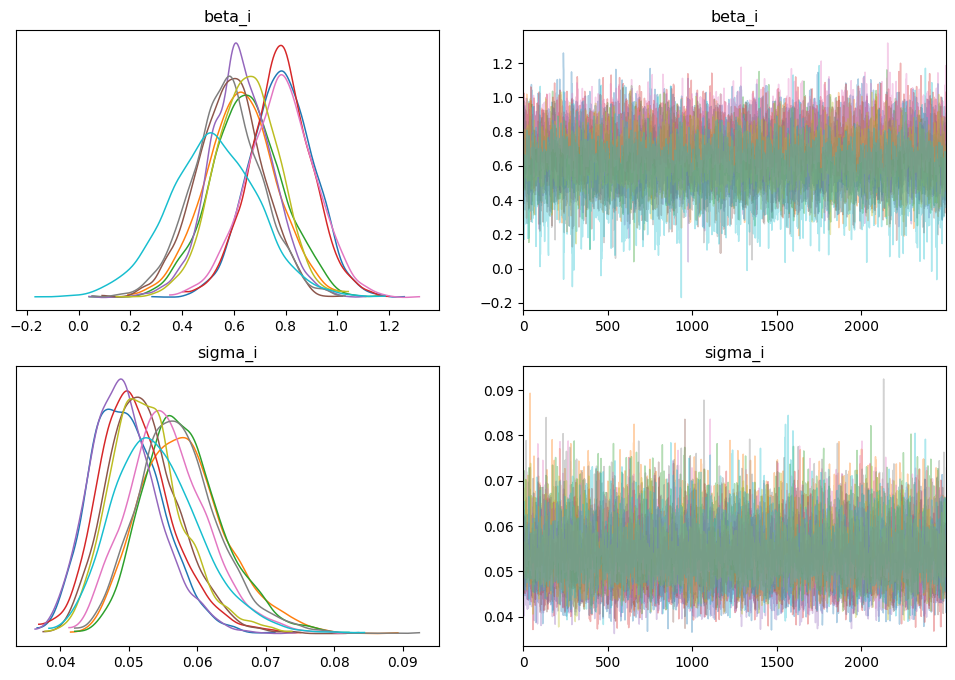

In [ ]:
with m_baseline:
    az.plot_trace(traces_baseline, figsize=(12,8))

> From the graph of the posterior distributions of individual stock's betas, we noticed that the distributions were centered between [.4, 1]. This differed from our guess about the prior distribution, which based on beta of the portfolio, we had guessed to be a Normal distribution with $\mu = 1.5$ and $\sigma = 2$. From the posterior distribution of the stocks and after taking $\sigma$ market disturbances into account, it seems that the banking firms either move with the market or have a lower volatility than the market.  

In [ ]:
beta_values = traces_baseline

In [ ]:
posterior_samples = beta_values.posterior["beta_i"]
posterior_samples = posterior_samples.to_numpy()
posterior_samples

array([[[0.80834343, 0.60772331, 0.56831357, ..., 0.55863641,
         0.60365077, 0.59508158],
        [0.9099344 , 0.74064325, 0.73395948, ..., 0.61965325,
         0.67949653, 0.42727168],
        [0.59117849, 0.53843403, 0.55342232, ..., 0.62324446,
         0.61021949, 0.75583307],
        ...,
        [0.90651498, 0.79147082, 0.65142298, ..., 0.72603105,
         0.69205531, 0.67347806],
        [0.71402068, 0.52962498, 0.69889795, ..., 0.44520307,
         0.61580003, 0.35717327],
        [0.68437703, 0.49855047, 0.72725289, ..., 0.43953057,
         0.46271286, 0.46917076]]])

In [ ]:
beta = []
values = []

for i in range(len(tickers)):
  value = posterior_samples[0,i].mean()
  values.append(value)

data_beta = {'ticker': tickers, 'beta_i': values}
df_beta = pd.DataFrame(data_beta)

In [ ]:
df_er_ip = df_1.merge(df_beta, on = "ticker", how = "left")
df_er_ip

In [ ]:
# expected return = riskfree + beta_i(sp500 - riskfree)

er = df_er_ip['riskfree'] + df_er_ip['beta_i']*(df_er_ip['sp500'] - df_er_ip['riskfree'])
er = er.to_frame()
er.columns = ['expected_r']

In [ ]:
df_er = pd.merge(df_er_ip, er, left_index=True, right_index=True)
df_er

,dt,ticker,price,weekly_return,riskfree,sp500,beta_i,expected_r
0,2022-01-08,BAC,45.406059,-0.025824,0.001768,-0.056813,0.684464,-0.038328
1,2022-01-15,BAC,42.572323,-0.062409,0.002383,0.007710,0.684464,0.006030
2,2022-01-22,BAC,43.472672,0.021149,0.003315,0.015497,0.684464,0.011653
3,2022-01-29,BAC,45.756721,0.052540,0.003766,-0.018196,0.684464,-0.011266
4,2022-02-05,BAC,45.415535,-0.007457,0.004149,-0.015790,0.684464,-0.009498
...,...,...,...,...,...,...,...,...
495,2022-09-17,WFC,38.932926,-0.080337,0.059250,0.011321,0.701536,0.025626
496,2022-09-24,WFC,38.749870,-0.004702,0.060854,-0.033725,0.701536,-0.005497
497,2022-10-01,WFC,40.262482,0.039035,0.061823,-0.020847,0.701536,0.003827
498,2022-10-08,WFC,41.592037,0.033022,0.062903,-0.001957,0.701536,0.017401


In [ ]:
df_er_1 = df_er.merge(ftxo_weights_df, on = "ticker")

In [ ]:
df_er_1['combined_weight'] = 0.1

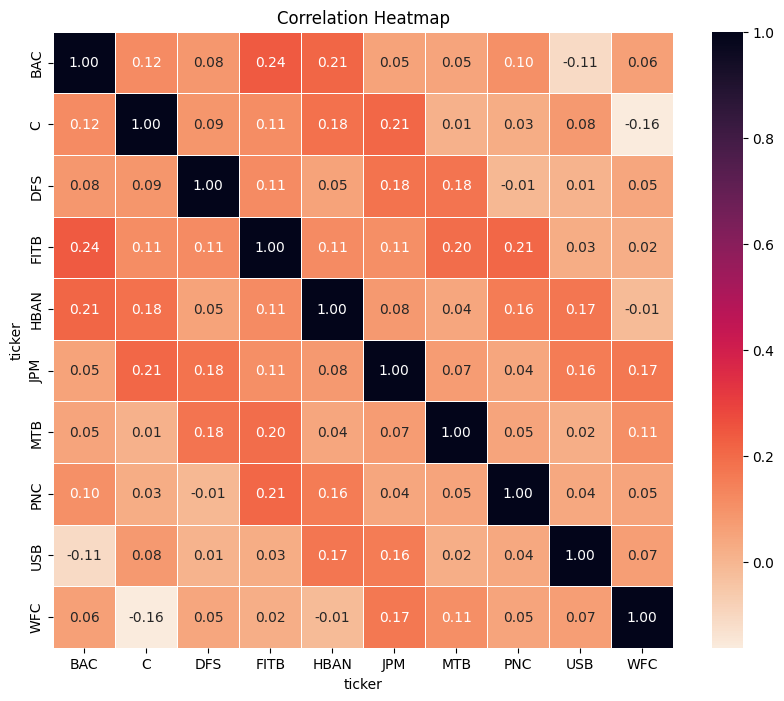

In [ ]:
import seaborn as sns

# Select relevant columns
selected_columns = ['ticker', 'expected_r']

# Pivot the data to get ticker-wise returns
returns_pivot = df_er_1[selected_columns].pivot_table(index=df_er_1['dt'], columns='ticker', values='expected_r')

# Calculate the correlation matrix
correlation_matrix = returns_pivot.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap = 'rocket_r', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

> The correlation heat map of the stocks shows how much the stocks move with each other and will give us an idea of the possible level of systemic risk in the banking industry. As can be seen by the heat map of the firms, the correlation between the stocks is relatively small. This hints at the idea that the banking firms don’t seem to be moving together. We had expected that since our portfolio is based on stocks in the same industry, we would see the stocks expected returns to be moving together and would be impacted by various factors in the same way, however, the heat map seems to be indicating otherwise.

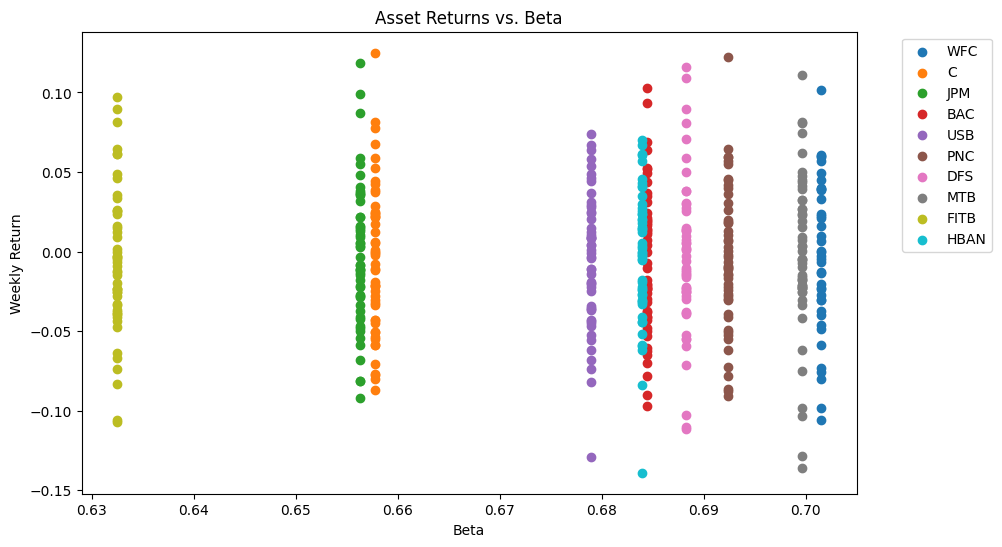

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = df_er_1[df_er_1['ticker'].isin(["WFC", "C", "JPM", "BAC", "USB", "PNC", "DFS", "MTB", "FITB", "HBAN"])]
data = data[['ticker', 'weekly_return', 'beta_i']]

# Pivot the data to have tickers as columns
pivoted_data = data.pivot(columns='ticker', values=['weekly_return', 'beta_i'])

# Plot individual asset returns and risks
plt.figure(figsize=(10, 6))
for asset in ["WFC", "C", "JPM", "BAC", "USB", "PNC", "DFS", "MTB", "FITB", "HBAN"]:
    plt.scatter(pivoted_data['beta_i'][asset], pivoted_data['weekly_return'][asset], label=asset)

plt.title('Asset Returns vs. Beta')
plt.xlabel('Beta')
plt.ylabel('Weekly Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The scatter plot displayed above visualizes each of the stocks estimated mean beta values and the dispersion of the expected returns that were calculated based on estimated beta and market data.

## Conclusion



> Our goal for our project was to better understand the applications of MCMC methods in a financial analysis context. To achieve this goal, we used the PyMC package to execute the MCMC algorithm and built our model using CAPM to calculate expected returns of our portfolio to simulate portfolio behavior and sensitivity to market uncertainty.

> Throughout our project, we were able to apply the concepts we learned in the course to an application of interest to us. As economists, it is important to understand the intricacies of market behavior and for those that are interested in financial analysis, understanding portfolio behavior given changing economic environments is of deep interest. We hope that the analysis of our own portfolio can then be applied to other financial contexts for modelling and simulating portfolio behavior.

> We hope our project can serve as a stepping stone for future research in this field and primarily as students, to serve as a learning opportunity in the fields of economics, finance, and computational social science. A potential application of our project in the future would be building the efficiency frontier to analyze optimal stock weights in the portfolio. This was a goal we were hoping to achieve, however, with the existing intricacies of our data and MCMC algorithm, we were unable to do so. The flexibility of the MCMC algorithm and PyMC package allow it to be applied to a variety of contexts, so while we selected modelling portfolio behavior for our project, any other application of these methods in other fields of study would be of interest.